## Import
En primer lugar, se importan todas las librerías que se utilizarán.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import shuffle
from sklearn.svm import SVC
import seaborn as sns
import math

## Carga de datos
Los datos son cargados utilizando al librería "Pandas", de los archivos train.csv y test.csv. Luego se transforman en objetos "numpy" para facilitar su operación.

Se juntan las columnas de los arrays `X_train` y `y_train` en `samples_array`, para poder mezclar los datos sin perder la relación entre ellos.

In [2]:
train_df = pd.read_csv("./data/train.csv", sep=',', usecols=range(1,4))
test_df = pd.read_csv("./data/test.csv", sep=',', usecols=range(1,4))

print('Cantidad de datos de entrenamiento = ' + str(len(train_df.index)))
print('Cantidad de datos de prueba = ' + str(len(test_df.index)))      
train_df.head()

Cantidad de datos de entrenamiento = 320
Cantidad de datos de prueba = 80


,V1,V2,label
0,-0.939381,-0.395176,-1.0
1,-2.999302,-1.082222,-1.0
2,2.154991,-2.355406,1.0
3,1.434488,1.755529,1.0
4,-0.974204,-0.878194,-1.0


In [3]:
train = train_df.to_numpy() # Train set
test = test_df.to_numpy() # Test set

X_train = train[:,0:2]
y_train = train[:,2].astype(int)
X_test = test[:,0:2]
y_test = test[:,2].astype(int)

samples_array = np.zeros((X_train.shape[0],X_train.shape[1]+1))
samples_array[:,0:2] = X_train
samples_array[:,2] = y_train

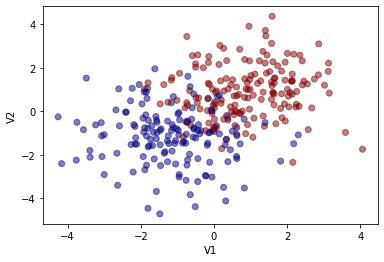

In [4]:
from matplotlib.cm import ScalarMappable
fig_class, ax = plt.subplots()
sc = ax.scatter(X_train[:,0], X_train[:,1], alpha=0.5,c=y_train,cmap='jet')
ax.set_xlabel('V1')
ax.set_ylabel('V2');
# fig_class.colorbar(sc)

## Funciones
Se definen funciones necesarias para la el cálculo del gradiente descendiente.

La función `loss` calcula la función costo J, que debe minimizarse.
<img src="./img/loss.png" alt="loss" style="width: 400px;"/>

La función `get_grad` devuelve las tres componentes del gradiente de la función costo (w1,w2,b). Las derivadas son calculadas de la siguiente forma:

<img src="./img/grad.png" alt="grad" style="width: 500px;"/>

La función `get_line` devuelve una recta para w y b.

`plot_train_test` plotea los puntos de train y test, divididos por la recta correspondiente a w y b.

In [5]:
def loss(W, xy, C=1):
    (X,Y) = xy
    X = np.array(X)
    Y = np.array(Y)
    w = np.array(W[0])
    b = np.array(W[1])
    
    acum = 0
    for x,y in zip(X,Y):
        acum += max(0,1-y*(w.T@x+b))
        
    return .5 * (np.linalg.norm(w)**2.) + C * acum

def get_grad(W, xy, C=1):
    (X,Y) = xy
    X = np.array(X)
    Y = np.array(Y)
    w = np.array(W[0])
    b = np.array(W[1])
    
    grad = np.zeros(3)
    der_b = 0.
    der_w1 = 0.
    der_w2 = 0.
    for x,y in zip(X,Y):
        if (y*(w.T@x + b) < 1):
            der_w1 += y*x[0]
            der_w2 += y*x[1]
            der_b += y
    grad[0] = w[0] - C * der_w1
    grad[1] = w[1] - C * der_w2
    grad[2] = - C * der_b
    return grad 

def get_line(x,w,b):
    # Ax+By+C = 0 => y = - C/B - A/C x
    # A=w0, B=w1, C=b => y = -b/w1 - w0/w1 x
    return -b/w[1] - (w[0]/w[1])*x

def plot_train_test(w,b):
    x_axis = np.linspace(-5, 5, 100)
    line = get_line(x_axis,w,b)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20,10])
    # fig.suptitle(' ')
    ax1.scatter(X_train[:,0], X_train[:,1], alpha=0.5, c=y_train,cmap='jet')
    ax1.plot(x_axis, line, linewidth=2)
    ax1.set_xlabel('V1', size=2)
    ax1.set_ylabel('V2', size=2)
    ax2.scatter(X_test[:,0], X_test[:,1], alpha=0.5, c=y_test,cmap='jet')
    ax2.plot(x_axis, line, linewidth=2)
    ax2.set_xlabel('V1', size=2)
    ax2.set_ylabel('V2', size=2)
    
def plot_train_test_compare(w1,b1,label1,w2,b2,label2):
    x_axis = np.linspace(-5, 5, 100)
    line1 = get_line(x_axis,w1,b1)
    line2= get_line(x_axis,w2,b2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20,10])
    # fig.suptitle(' ')
    
    ax1.scatter(X_train[:,0], X_train[:,1], alpha=0.5, c=y_train,cmap='jet')
    ax2.scatter(X_test[:,0], X_test[:,1], alpha=0.5, c=y_test,cmap='jet')
    
    ax1.plot(x_axis, line1, label=label1, linewidth=2)
    ax2.plot(x_axis, line1, label=label1, linewidth=2)
    ax1.plot(x_axis, line2, label=label2, linewidth=2)
    ax2.plot(x_axis, line2, label=label2, linewidth=2)
    
    ax1.set_xlabel('V1', size=2)
    ax1.set_ylabel('V2', size=2)
    ax2.set_xlabel('V1', size=2)
    ax2.set_ylabel('V2', size=2)
    
    ax1.legend(loc="upper right", fontsize=14)
    ax2.legend(loc="upper right", fontsize=14)
    

## Implementación de Stochastic Gradient Descent (SGD)
En la siguiente sección se implementa el gradiente descendiente estocástico para encontrar los valores óptimos de w y b que minimizan la función costo J.

La función `SGD_update` realiza la actualización de las variables w1, w2 y b, en fución del gradiente calculado.

`run_SGD` realiza un loop de la cantidad de épocas pasadas como parámetro. En cada ciclo se toma una muestra aleatorea del conjunto de datos, de tamaño batch_size. Se cálcula el gradiente con ese batch y se actualizan los valores de w y b.

Finalmente, se verifica si hubo mejora en la función costo (J). Si J se mantiene sin mejorar por 'patient' épocas, se corta la ejecución.

In [6]:
def SGD_update(w, b, grad, alpha):
    w[0] = w[0] - alpha*grad[0]
    w[1] = w[1] - alpha*grad[1]
    b    = b    - alpha*grad[2]
    return w,b

def run_SGD(w_ini=[1.,1.],b_ini=0.,C=1.,learning_rate=0.001,
            batch_size=100,epoch=100,patient=-1):
    
    w = np.array(w_ini)
    b = np.array(b_ini)
    
    j_train = []
    best_j = -1
    count_error = 0
    first_time = True
    num_samples = samples_array.shape[0]
    
    for ep in range(epoch):
        # Mezclo los datos y tomo muestra de tamaño batch_size
        shuffle(samples_array)
        batch_samples = samples_array[0:min(batch_size,num_samples)]
        x_batch = np.array(batch_samples[:,0:2])
        y_batch = np.array(batch_samples[:,2])
            
        # Obtengo el gradiente y actualizo los párametros
        grad = get_grad([w,b], xy=(x_batch,y_batch), C=C)
        w,b = SGD_update(w, b, grad, alpha = learning_rate)

        # Acumulo los errores
        # j_train.append(loss([w,b], xy=(x_batch,y_batch), C=C))
        j_train.append(loss([w,b], xy=(X_train,y_train), C=C))

        # Corte anticipado
        if(patient>=0):
            if(not(first_time)):
                if j_train[-1] < best_j:
                    best_j = j_train[-1]
                    count_error = 0
                else:
                    count_error += 1
                    if(count_error >= patient):
                        print("Función J no mejoró por "+str(count_error)+" épocas => STOP")
                        break            
            else:
                first_time = False
                best_j = j_train[-1]
            
    return w, b, j_train

A continuación, se usa el descenso del gradiente para encontrar los valores óptimos de w y b. En primer lugar, se definen los valores iniciales de w y b y los parámetros:
- learning_rate: tasa de aprendizaje
- batch_size: tamaño del lote
- epoch: cantidad de épocas
- patient: si la función costo (J) no mejora por 'patient' épocas, se corta la ejecución

Luego, se computa el gradiente y se grafica el error de train.

En este ejemplo, la cantidad de epócas se configura en un número extremadamente alto, para que se realice el corte automático de la ejecución, basado en patient.

Función J no mejoró por 80 épocas => STOP
w = [0.64479568 0.57518654], b = 0.3350000000000095
J_train = 10.136646606394219, J_test = 2.123205296619837


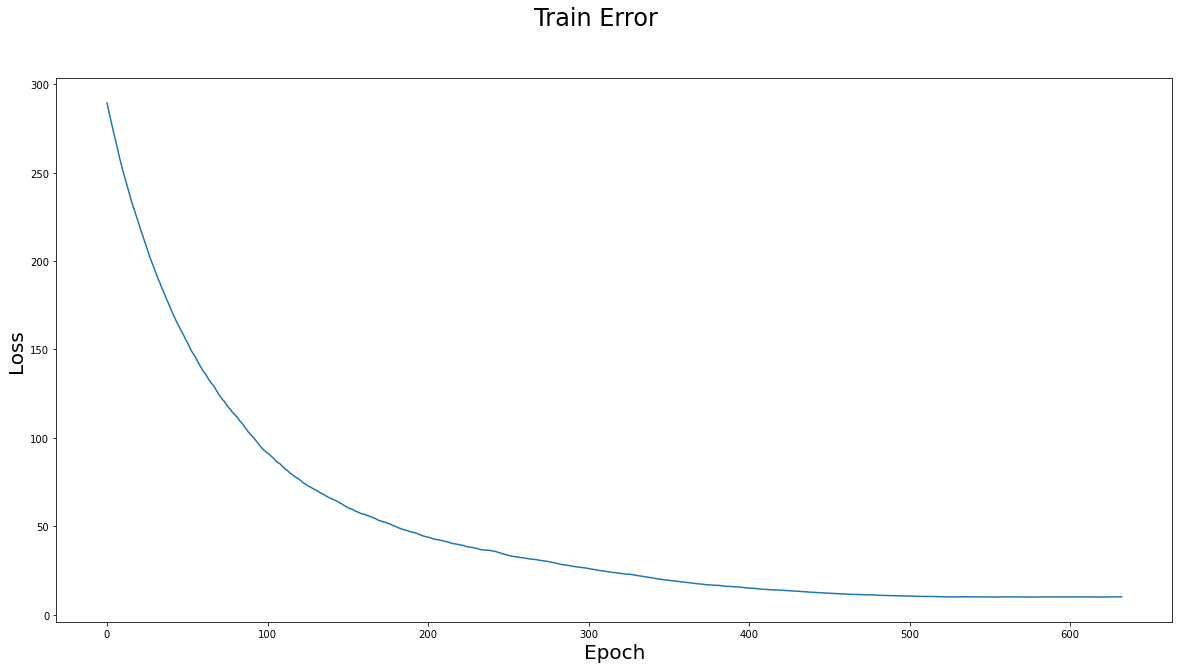

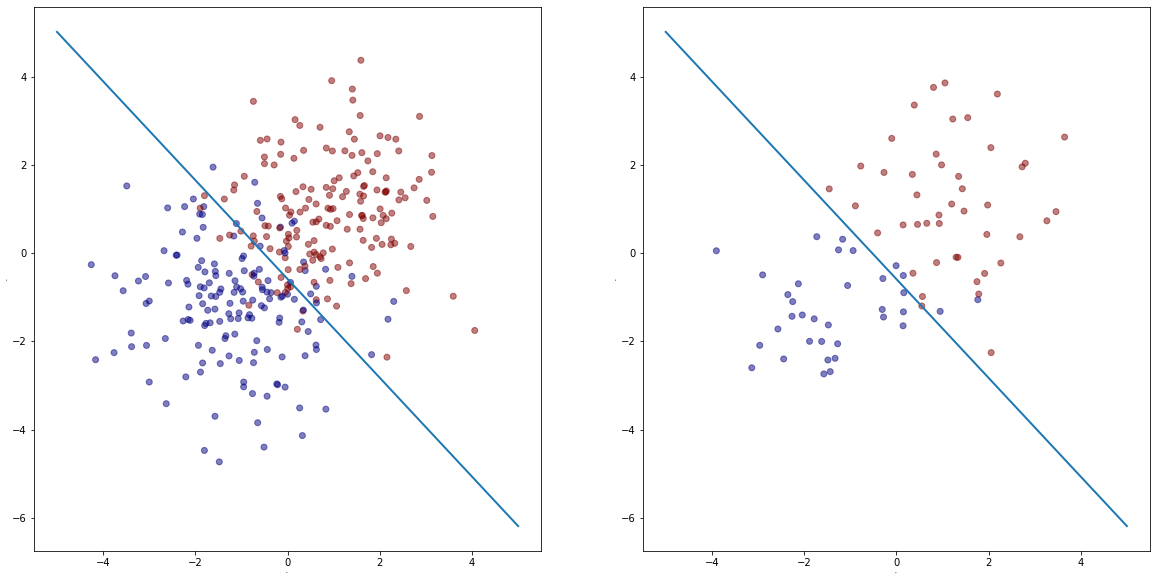

In [7]:
# Configuración de valores iniciales e hiperparametros
w_ini = np.random.uniform([-10,10],2)
b_ini = 10.
C = .1
learning_rate = 0.01
batch_size = 60
epoch = 10000
patient = 80

w, b, j_train = run_SGD(w_ini, b_ini, C, learning_rate, 
                            batch_size, epoch, patient)
j_test = loss([w,b], xy=(X_test,y_test), C=C)
print("w = " + str(w) + ", b = "+ str(b))
print("J_train = " + str(j_train[-1]) + ", J_test = "+ str(j_test))
fig, ax = plt.subplots(figsize=[20,10])
ax.set_xlabel('Epoch', size=20)
ax.set_ylabel('Loss', size=20)
fig.suptitle('Train Error', fontsize=24)
ax.plot(np.linspace(0,len(j_train)-1,len(j_train)),j_train)

plot_train_test(w,b)

## Modificación de parámetros de entremamiento
A continuación se modifican los parámetros de entrenamiento, y se observa como varían los resultados. Los paráemtros a modificar son:

- Batch Size
- Learning Rate
- Regularización (C)

La cantidad de épocas en cada prueba se mantiene constante en 500, (sin corte anticipado) para tener una mejor comparación de los resultados.

##### Batch Size
Se realiza el entrenamiento con distintos tamaños de batch. Se puede observar que a medida que el tamaño de batch aumenta, el error converge más rapido y con menos ruido al valor final.

Particularmente, cuando el tamaño del batch es muy chico, el gradiente tiene más probabilidades de dar como resultado una dirección erronea, debido a que se están utilizando pocos datos para su cálculo. Es por esto que el valor de loss (J) puede aumentar entre una época y otra, y converge con más ruido hacia el valor final.

Hay que tener en cuenta que al aumentar el tamaño del batch, se están procesando mayor cantidad de datos en cada época, por lo que esta velocidad de convergencia se paga con mayores requerimientos de cómputo.

 
batch_size: 10
w = [0.50925939 0.59437251], b = 7.659999999999959
J_train = 113.15143160948763, J_test = 25.614214994238683
 
batch_size: 50
w = [0.97648154 0.84598292], b = 1.3260000000000212
J_train = 12.669803738656976, J_test = 3.115861346368344
 
batch_size: 100
w = [0.66608322 0.73050627], b = 0.3100000000000046
J_train = 9.758732430581553, J_test = 2.0864935437916468
 
batch_size: 150
w = [0.71540503 0.78108023], b = 0.31100000000000605
J_train = 9.625486584108396, J_test = 2.086893025147005
 
batch_size: 320
w = [0.8758654  0.89799986], b = 0.4120000000000018
J_train = 9.511271789251996, J_test = 2.208272501149537


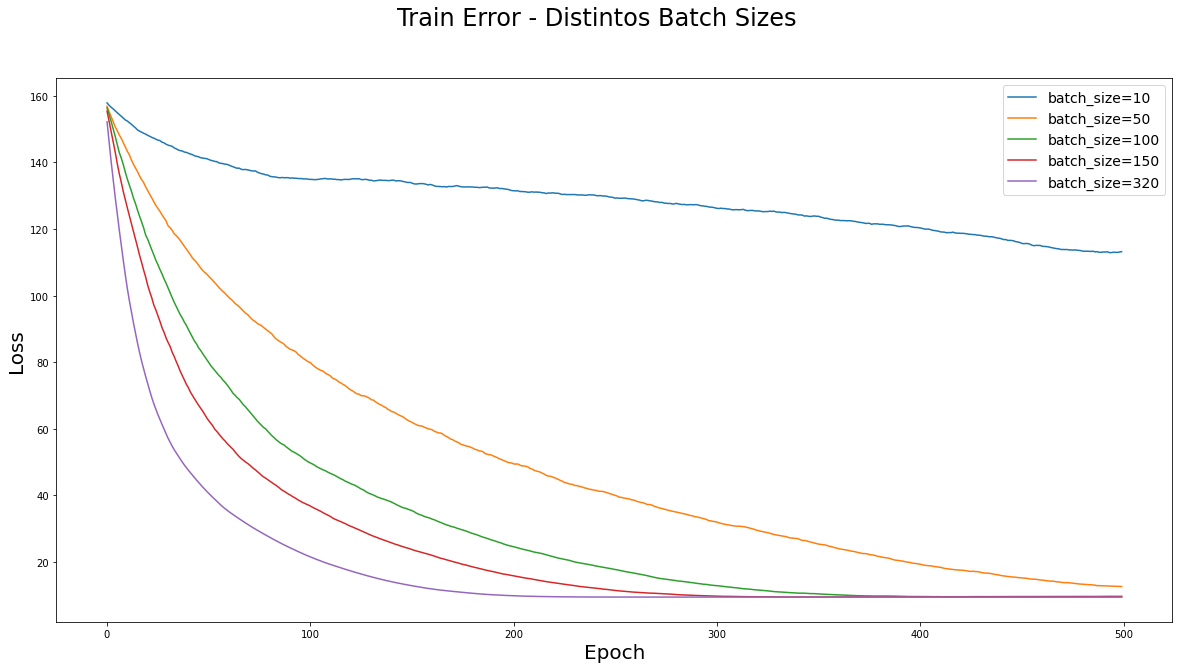

In [16]:
# Configuración de valores iniciales e hiperparametros
w_ini = np.random.uniform([-10,10],2)
b_ini = 10.
C = .1
learning_rate = 0.01
batch_size_vector = [10,50,100,150,320] 
epoch = 500

fig, ax = plt.subplots(figsize=[20,10])
fig.suptitle('Train Error - Distintos Batch Sizes', fontsize=24)
ax.set_xlabel('Epoch', size=20)
ax.set_ylabel('Loss', size=20)
for batch_size in batch_size_vector:
    w, b, j_train = run_SGD(w_ini, b_ini, C, learning_rate, 
                                batch_size, epoch)
    j_test = loss([w,b], xy=(X_test,y_test), C=C)
    
    print(" ")
    print("batch_size: "+str(batch_size))
    print("w = " + str(w) + ", b = "+ str(b))
    print("J_train = " + str(j_train[-1]) + ", J_test = "+ str(j_test))
    ax.plot(np.linspace(0,epoch-1,epoch),j_train,label='batch_size='+str(batch_size))

ax.legend(loc="upper right", fontsize=14)

##### Learning Rate (alpha)
En las gráficas siguientes se puede ver que a medida que el learning rate aumenta, la convergencia hacia el valor final se hace cada vez más rápida. Sin embargo, si el valor es demasiado gránde, el resultado final podría oscilar y no converger, o más aún, podría diverger.

Esto se debe a que este valor controla el "paso" de actualización del gradiente en cada época. Observando las ecuaciones:

    - w = w - alpha * grad(w)    
    - b = b - alpha * grad(b)
se ve fácilmente que el learning rate (alpha) pondera el cambio en el gradiente en cada iteración. Es por esto que si el valor es muy pequeño, las variaciones de los valores de w y b entre cada iteración serán pequeñas y se tardará más tiempo en llegar al valor final. Por el contrario, se alpha es grande los cambios en las variables serán más bruscos, y los saltos de valores entre una iteración y otra serán mayores. En este último caso, es fácil ver que en las zonas proximas al gradiente, un gran cambio en las variables (w y b) podría derivar en "modificar de más" dicha variable y "pasarnos" del valor óptimo.

 
learning_rate: 0.001
w = [1.2069597  6.18697588], b = 8.752699999999987
J_train = 76.75167531909499, J_test = 29.42942051686289
 
learning_rate: 0.01
w = [0.70540802 0.75308076], b = 0.3320000000000102
J_train = 9.669365445253046, J_test = 2.0948992488021982
 
learning_rate: 0.05
w = [0.65700517 0.67920024], b = 0.28000000000000125
J_train = 9.836628446072336, J_test = 2.0768682699413246
 
learning_rate: 0.1
w = [0.69948134 0.67705728], b = 0.2800000000000002
J_train = 9.763820716213736, J_test = 2.0742620165940617
 
learning_rate: 0.5
w = [0.83479305 0.35956459], b = 0.3500000000000012
J_train = 10.949875221718525, J_test = 2.358319347035996


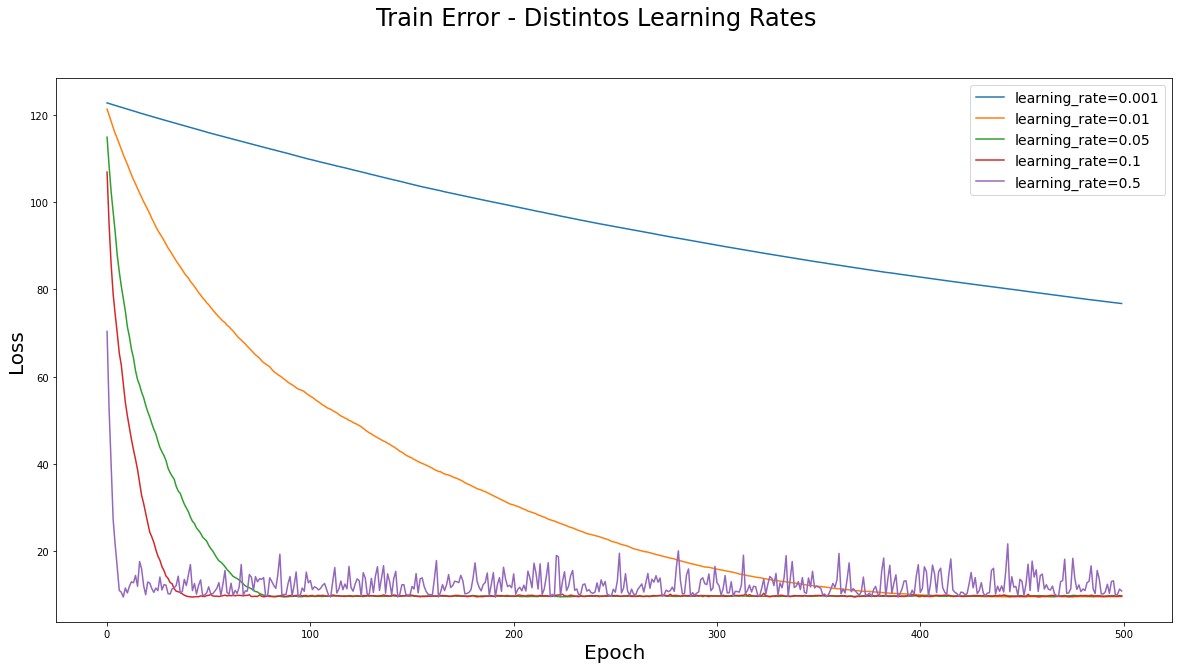

In [9]:
# Configuración de valores iniciales e hiperparametros
w_ini = np.random.uniform([-10,10],2)
b_ini = 10.
C = .1
learning_rate_vector = [.001,.01,.05,.1,.5]
batch_size = 100
epoch = 500

fig, ax = plt.subplots(figsize=[20,10])
fig.suptitle('Train Error - Distintos Learning Rates', fontsize=24)
ax.set_xlabel('Epoch', size=20)
ax.set_ylabel('Loss', size=20)
for learning_rate in learning_rate_vector:
    w, b, j_train = run_SGD(w_ini, b_ini, C, learning_rate, 
                                batch_size, epoch)
    j_test = loss([w,b], xy=(X_test,y_test), C=C)
    
    print(" ")
    print("learning_rate: "+str(learning_rate))
    print("w = " + str(w) + ", b = "+ str(b))
    print("J_train = " + str(j_train[-1]) + ", J_test = "+ str(j_test))
    ax.plot(np.linspace(0,epoch-1,epoch),j_train,label='learning_rate='+str(learning_rate))

ax.legend(loc="upper right", fontsize=14)

##### Regularización (C)
En las gráficas siguientes podemos ver que el valor de C modifica en gran medida el valor final del error de train. En menor medida, se ve modificada la velocidad de convergencia.

Para entender el cambio en el valor final, debemos observar las derivadas de la función loss, en la función `get_grad`. Tomando como ejemplo el gradiente de b:

    - grad[b] = - C * der_b
`der_b` se calcula como la sumatoria de los errores, por lo que sera un número entero. Si tomamos un C relativamente grande como C=1, cuando la cantidad de errores está cercana a 0 el gradiente tenderá a tomar valores '0', '±1' o a lo sumo '±2'. Es decir que no se le permite al gradiente tomar valores menores a 1 en valor absoluto. Esto produce que el error se estanque y oscile en valores relativamente grandes, ya que el gradiente no puede hacerse lo suficientemente pequeño para seguir convergiendo a un valor final óptimo.

Algo similar ocurre con el termino de w, aunque no es tan directo de verlo por la forma en que se calcula el acumulado y el gradiente.

 
C: 0.01
w = [0.51151736 0.59652842], b = 7.679499999999982
J_train = 11.61524106601701, J_test = 2.8443582055388177
 
C: 0.1
w = [0.67248926 0.69071697], b = 0.2730000000000191
J_train = 9.782081647647162, J_test = 2.070525194738045
 
C: 0.5
w = [0.9572095  1.01335169], b = 0.44500000000000095
J_train = 43.89933887332978, J_test = 7.797965684182289
 
C: 1
w = [1.06832144 0.95005625], b = 0.3999999999999995
J_train = 86.97844897137219, J_test = 14.452403611711057
 
C: 2
w = [1.18726686 1.10914832], b = 0.620000000000001
J_train = 172.90325334007775, J_test = 28.05371095584376


(0.0, 300.0)

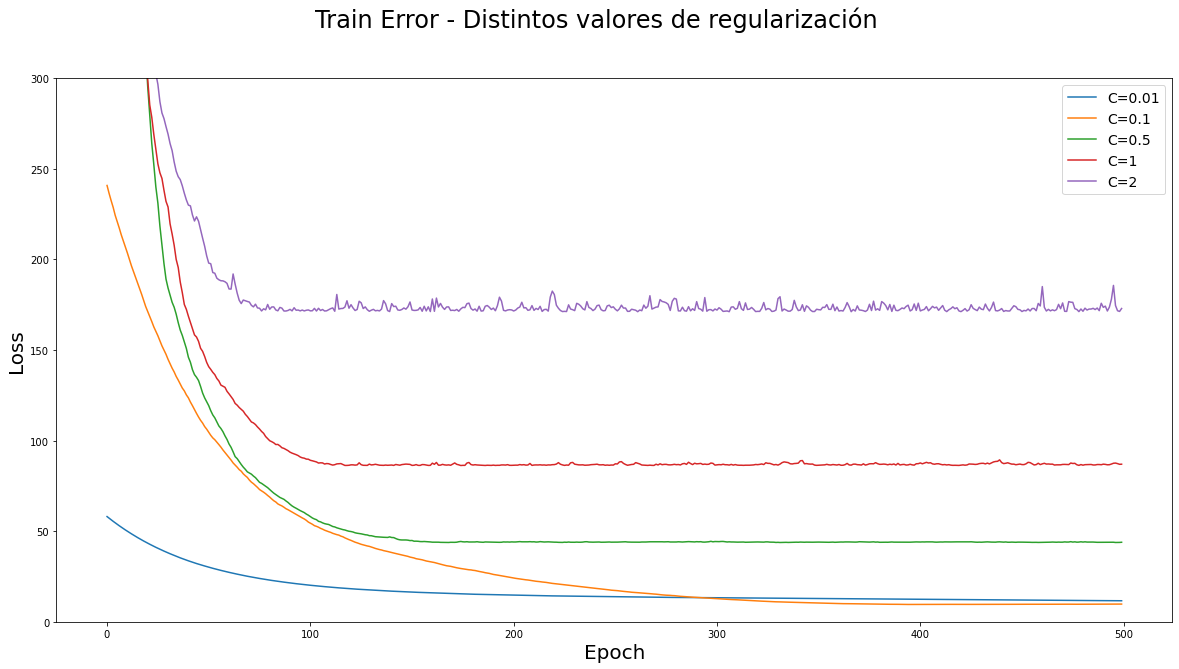

In [10]:
# Configuración de valores iniciales e hiperparametros
w_ini = np.random.uniform([-10,10],2)
b_ini = 10.
C_vector = [.01,.1,.5,1,2]
learning_rate = .01
batch_size = 100
epoch = 500

fig, ax = plt.subplots(figsize=[20,10])
fig.suptitle('Train Error - Distintos valores de regularización', fontsize=24)
ax.set_xlabel('Epoch', size=20)
ax.set_ylabel('Loss', size=20)
for C in C_vector:
    w, b, j_train = run_SGD(w_ini, b_ini, C, learning_rate, 
                                batch_size, epoch)
    j_test = loss([w,b], xy=(X_test,y_test), C=C)
    
    print(" ")
    print("C: "+str(C))
    print("w = " + str(w) + ", b = "+ str(b))
    print("J_train = " + str(j_train[-1]) + ", J_test = "+ str(j_test))
    ax.plot(np.linspace(0,epoch-1,epoch),j_train,label='C='+str(C))

ax.legend(loc="upper right", fontsize=14)
ax.set_ylim([0, 300])

Finalmente, se adopta una configuración para el entrenamiento, y se guardan los valores finales en `w_best` y `b_best` para utilizarlos más adelante. 

También se realizan las predicciones para los valores del conjunto de prueba. Esto se hace a través el cálculo `np.sign(w@x + b)`, donde `x` es un punto del conjunto `x_test`. El resultado, se almacena en el vector `y_pred` que luego se compara con `y_test` haciendo el conteo de casos correctos y erroneos. Se calcula la precisión como "casos_correctos / casos_totales".

Por último, se grafican los resultados.

Función J no mejoró por 80 épocas => STOP
w = [0.71957864 0.69033482], b = 0.3180000000000167
J_train = 9.726334391299767, J_test = 2.0915699462252166
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
Muestras mal estimadas con implementación gradiente desciendiente = [8, 55, 63, 67, 79]


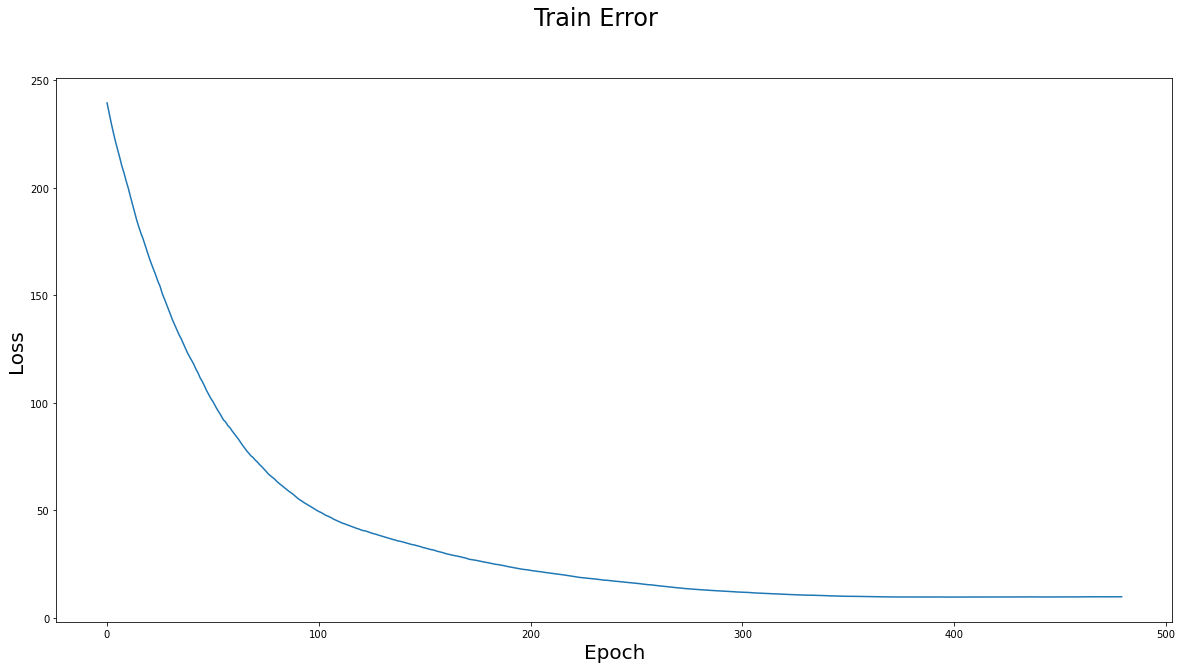

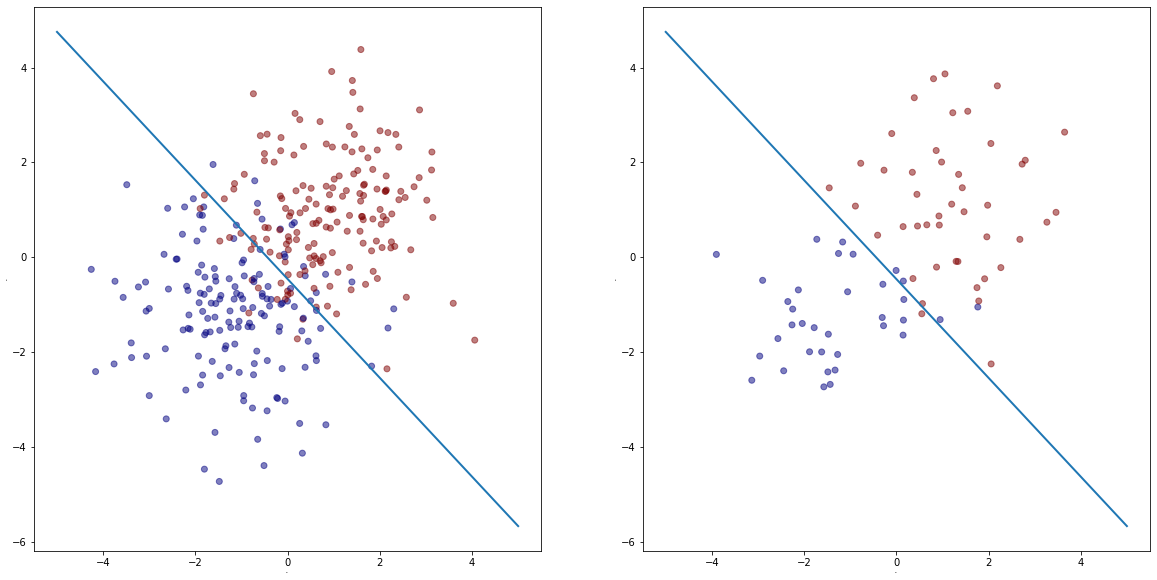

In [23]:
# Configuración de valores iniciales e hiperparametros
w_ini = np.random.uniform([-10,10],2)
b_ini = 10.
C = .1
learning_rate = .01
batch_size = 100
epoch = 10000
patient = 80

# Entrenar algoritmo
w, b, j_train = run_SGD(w_ini, b_ini, C, learning_rate, 
                            batch_size, epoch, patient)

# Calcular performance e imprimir resultados
j_test = loss([w,b], xy=(X_test,y_test), C=C)
y_pred_grad = [int(np.sign(w@x + b)) for x in X_test]
correct_grad = np.sum(y_pred_grad-y_test == 0)
score_grad = (correct_grad/len(y_test))
indx_err_grad = [i for i,e in enumerate((y_pred_grad-y_test)!=0) if(e)] # Ídicdes de muestra mal estimadas

print("w = " + str(w) + ", b = "+ str(b))
print("J_train = " + str(j_train[-1]) + ", J_test = "+ str(j_test))
print("Se predijeron correctamente "+str(correct_grad)+" de "+str(len(y_test))+" datos.")
print("Precisión = "+str(score_grad*100)+"%")
print("Muestras mal estimadas con implementación gradiente desciendiente = "+str(indx_err_grad))

# Realizar gráficas
fig, ax = plt.subplots(figsize=[20,10])
ax.set_xlabel('Epoch', size=20)
ax.set_ylabel('Loss', size=20)
fig.suptitle('Train Error', fontsize=24)
ax.plot(np.linspace(0,len(j_train)-1,len(j_train)),j_train)

plot_train_test(w,b)

# Guardar valores para usarlos en el futuro
w_best, b_best = w, b

## Implementación de SVM de Scikit-Learn
A continuación se realiza la implementación de SVM utilizando el modelo SVC lineal de la librería Scikit-Learn. El modelo es entrenado y testeado con los mismos datos que en el caso anterior.

Podemos ver que los resultados obtenidos son muy similares. Ambos metodos alcanzan la misma precisión, calculada como la proporción de etiquetas predichas correctamente. Observando los índices de las etiquetas erroneas, vemos que la mayoría de estas coinciden entre ambas implementaciones (los errores se dan para las mismas etiquetas).

Por otro lado, se ve también que los valores de w y b son cercanos, pero no iguales. Esto se debe a dos razones:
 - En primer lugar, hay una pequeña diferencia entre los dos planos obtenidos, que se ve gráficamente. Por lo tanto, es de esperar que los valores de w y b no coincidan.
 - Para el caso de w, hay que tener en cuenta que este vector marca la dirección del plano, por lo que existen infinitos valores de (w0,w1) que generan el mismo plano (para un valor fijo de b). Es por esto que se calcula también el ángulo que forma w con el eje de las abscisas. Vemos que estos ángulos son muy similares entre sí, aunque existe una pequeña diferencia.

SVM en Scikit-Learn: 
- Se predijeron correctamente 75 de 80 datos.
- Precisión = 93.75%
- w = [0.87458469 0.89832016], b = [0.4132359]
- Ángulo de w con eje x1 = 45.76702423927827
- Índices de muestras mal estimadas: [8, 55, 63, 67, 79]
 
SVM con gradiente descendente: 
- Se predijeron correctamente 75 de 80 datos.
- Precisión = 93.75%
- w = [0.71957864 0.69033482], b = 0.3180000000000167
- Ángulo de w con eje x1 = 43.81176574676312
- Índices de muestras mal estimadas: [8, 55, 63, 67, 79]


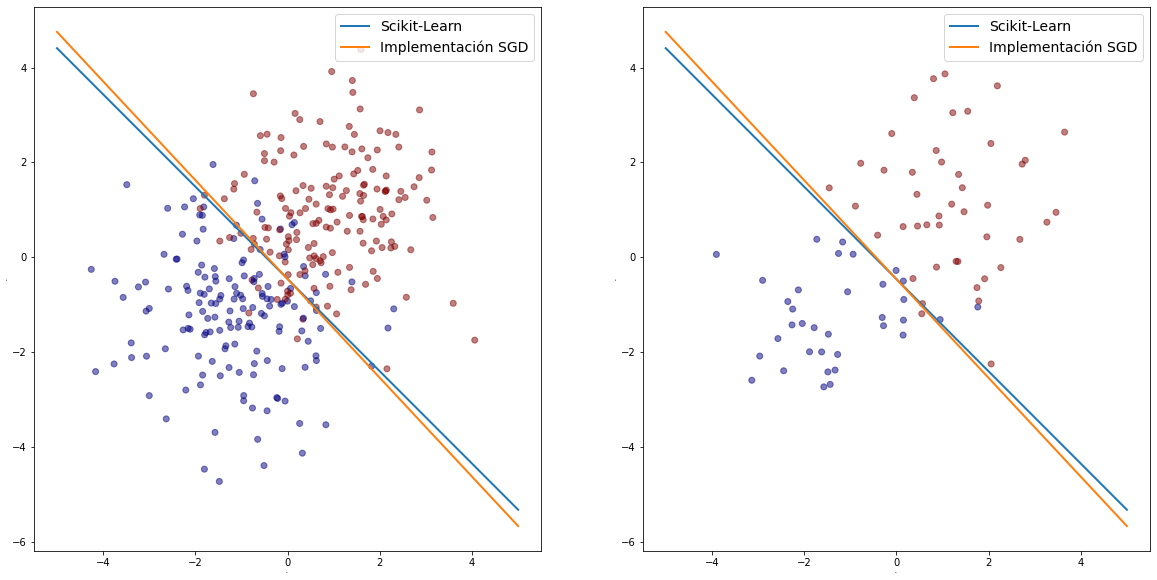

In [40]:
svm=SVC(kernel='linear',C=.1)
svm.fit(X_train,y_train)              # entrenar SVM
suport_vector = svm.support_vectors_  # vector soporte
suport_vector_vert =  svm.support_    # indices del vector soporte
w_skl = svm.coef_[0]                  # vector w
b_skl = svm.intercept_                # valor de b
score_skl = svm.score(X_test,y_test)  # score
y_pred_skl = svm.predict(X_test)      # predicciones
indx_err_skl = [i for i,e in enumerate((y_pred_skl-y_test)!=0) if(e)] # Ídicdes de muestra mal estimadas

# Resultados para Scikit-Learn
print("SVM en Scikit-Learn: ")
print("- Se predijeron correctamente "+str((y_test-y_pred_skl==0).sum())+
          " de "+str(len(y_test))+" datos.")
print("- Precisión = "+str(score_skl*100)+"%")
print("- w = " + str(w_skl) + ", b = "+ str(b_skl))
print("- Ángulo de w con eje x1 = "+ str(math.degrees(np.arctan2(w_skl[1],w_skl[0]))))
print("- Índices de muestras mal estimadas: "+str(indx_err_skl))

# Resultados para gradiente descendente
print(" ")
print("SVM con gradiente descendente: ")
print("- Se predijeron correctamente "+str(correct_grad)+" de "+str(len(y_test))+" datos.")
print("- Precisión = "+str(score_grad*100)+"%")
print("- w = " + str(w) + ", b = "+ str(b))
print("- Ángulo de w con eje x1 = "+ str(math.degrees(np.arctan2(w_best[1],w_best[0]))))
print("- Índices de muestras mal estimadas: "+str(indx_err_grad))

# Graficar ambas rectas
plot_train_test_compare(w_skl,b_skl,'Scikit-Learn',w_best,b_best,'Implementación SGD')

## Remover Vectores Soportes
En la siguiente sección se analiza cómo se ve afectada la performance del SVM al remover vectores soportes. Para esto se utiliza el arreglo `svm.support_ `, que devuelve el modelo `SVC`, para remover estos índices del los datos originales en `X_train`. Luego, se evalúa el modelo en todo el conjunto de prueba `x_test`.

Se repite el procedimiento removiendo diferentes cantidades de vectores soportes, y se grafican los resultados.

Vemos que en todos lo casos, varían los valores obtenidos de w y b respecto a los originales. Además, podemos ver gráficamente que los planos obtenidos son diferentes. Sin embargo la cantidad de vectores removidos no afecta demasiado a la precisión del modelo.

 
Removiendo 1 vectores soportes
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
w = [0.87382763 0.87724322], b = [0.36762419]
 
Removiendo 5 vectores soportes
Se predijeron correctamente 74 de 80 datos.
Precisión = 92.5%
w = [0.81899028 0.8687017 ], b = [0.38319336]
 
Removiendo 10 vectores soportes
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
w = [0.86753184 0.84322904], b = [0.38641596]
 
Removiendo 20 vectores soportes
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
w = [0.95173753 0.82453826], b = [0.25566316]


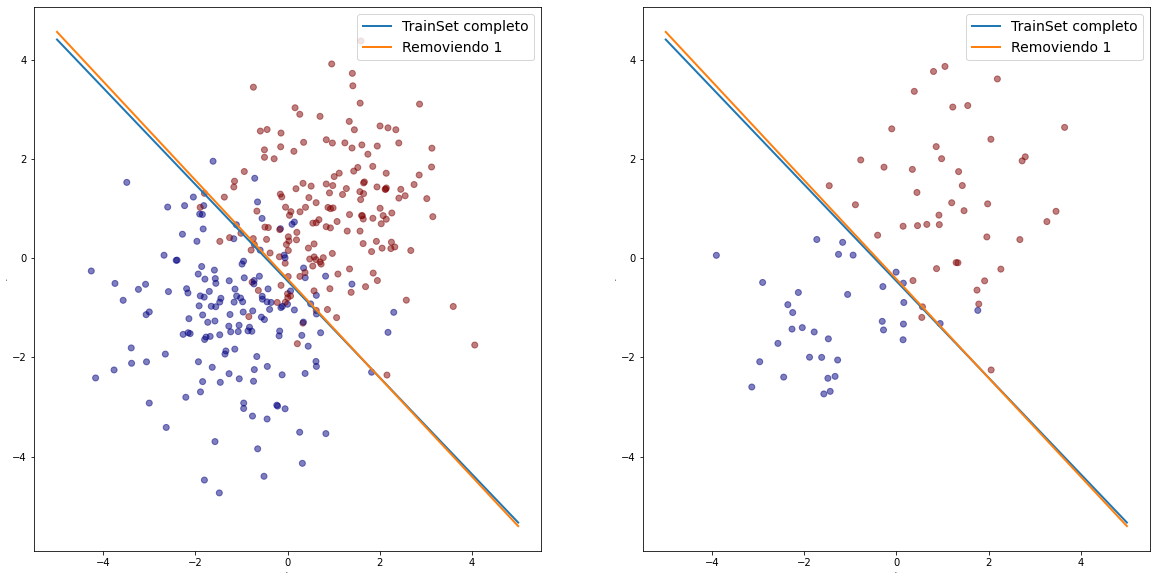

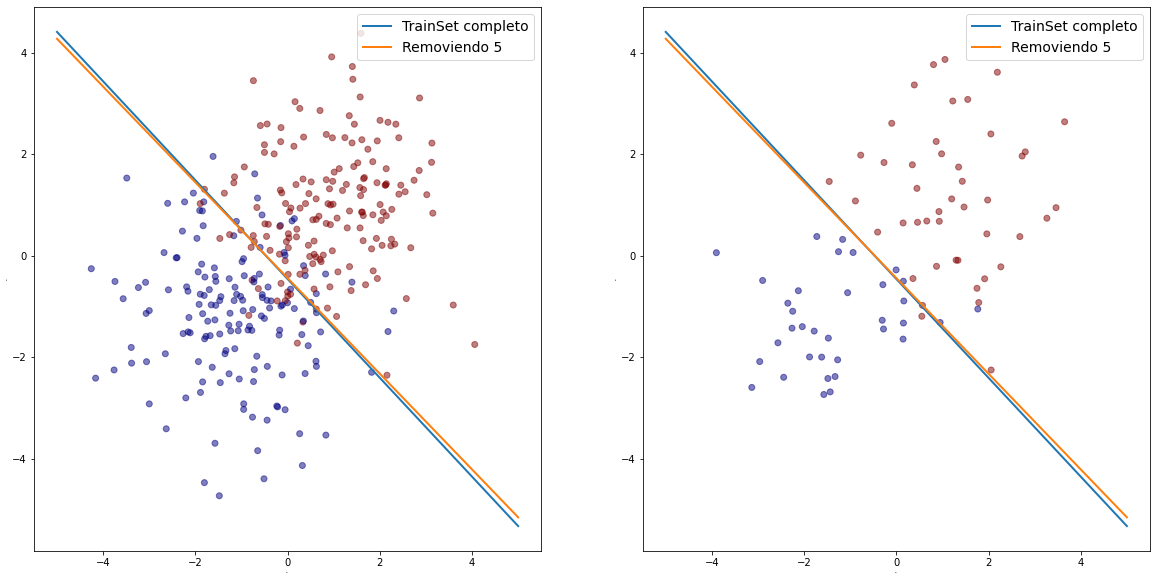

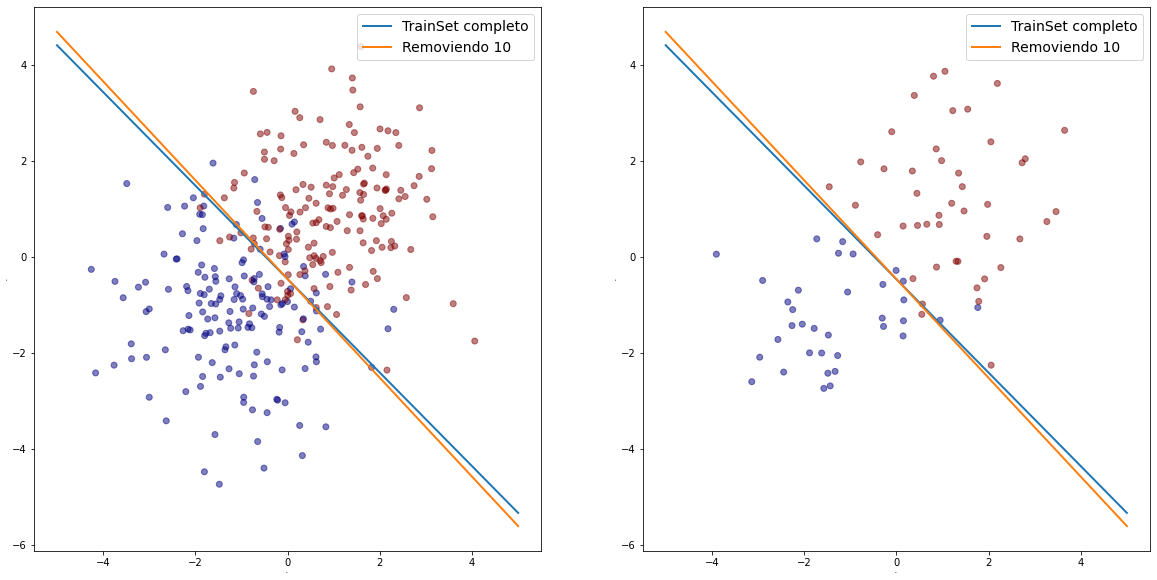

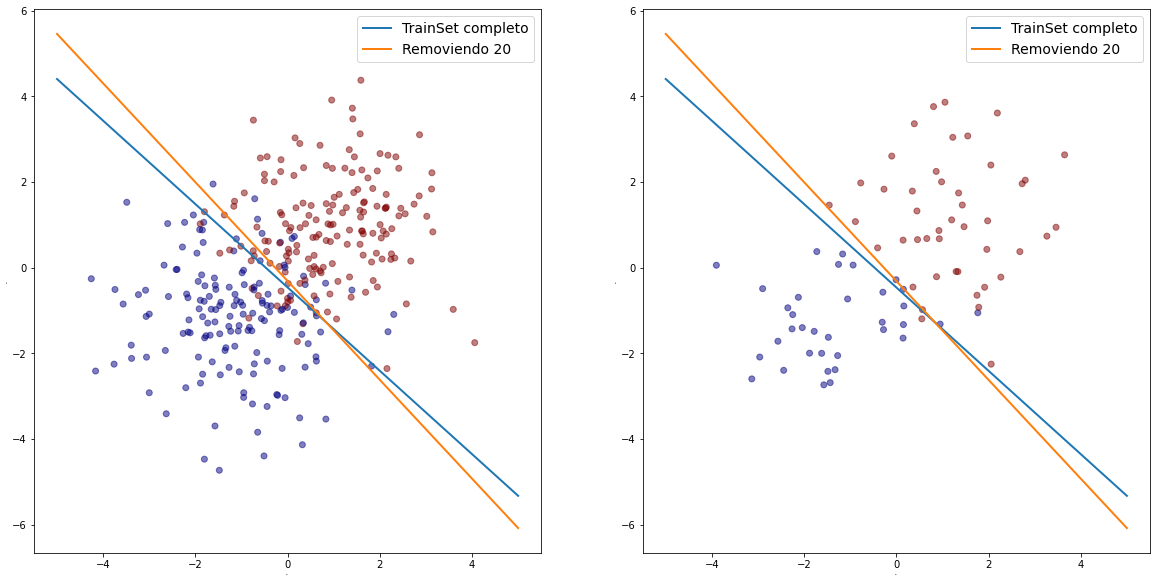

In [41]:
remove_vector = [1,5,10,20]
for cant in remove_vector:

    indx = np.random.choice(suport_vector_vert,size=cant,replace=False)
    indx = np.sort(indx)[::-1] # Remuevo del mayor al menor
    
    X_train_cut = X_train
    y_train_cut = y_train
    for i in indx:
        X_train_cut = np.delete(X_train_cut, i, 0)
        y_train_cut = np.delete(y_train_cut, i, 0)  
        
    svm=SVC(kernel='linear',C=.1)
    svm.fit(X_train_cut,y_train_cut)      # entrenar SVM
    w = svm.coef_[0]                      # vector w
    b = svm.intercept_                    # valor de b
    score = svm.score(X_test,y_test)      # score
    pred = svm.predict(X_test)            # predicciones
    print(" ")
    print("Removiendo "+str(cant)+" vectores soportes")
    print("Se predijeron correctamente "+str((y_test-pred==0).sum())+" de "+str(len(y_test))+" datos.")
    print("Precisión = "+str(score*100)+"%")
    print("w = " + str(w) + ", b = "+ str(b))
    
    plot_train_test_compare(w_skl,b_skl,"TrainSet completo",w,b,"Removiendo "+str(cant))

## Remover Vectores No Soportes
De manera análoga al caso anterior, se remueven datos del conjunto `X_train` que no son vectores soportes. En este caso, como era de esperar, los valores de w y b no se modifican respecto a los valores originales y, en consecuencia, el plano y la presición obtenida son iguales. A nivel gráfico, se observa que ambos planos coinciden.

Nota: en las gráficas, ambas rectas están superpuestas, por lo que sólo puede visualizarse una de las dos.

 
Removiendo 1 vectores soportes
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
w = [0.87458469 0.89832016], b = [0.4132359]
 
Removiendo 5 vectores soportes
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
w = [0.87458469 0.89832016], b = [0.4132359]
 
Removiendo 10 vectores soportes
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
w = [0.87461482 0.89835111], b = [0.41326163]
 
Removiendo 20 vectores soportes
Se predijeron correctamente 75 de 80 datos.
Precisión = 93.75%
w = [0.87458469 0.89832016], b = [0.4132359]


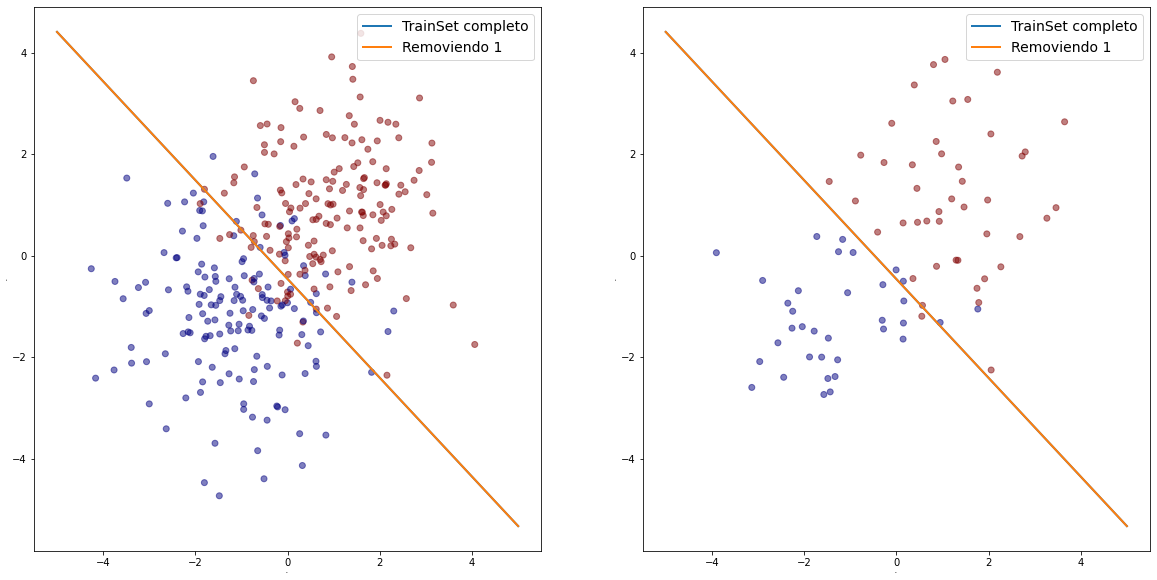

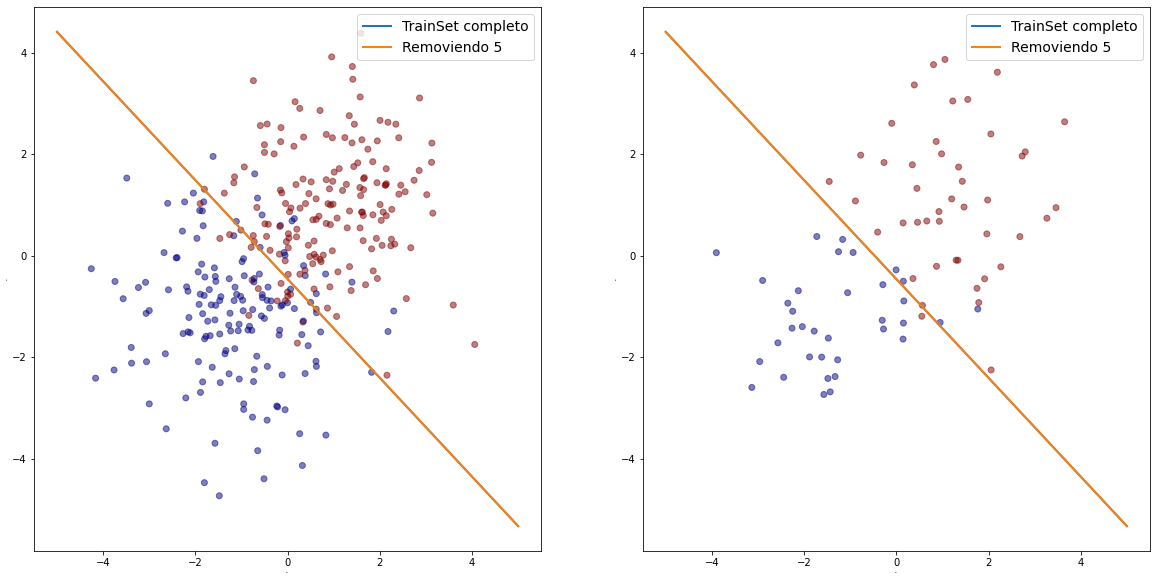

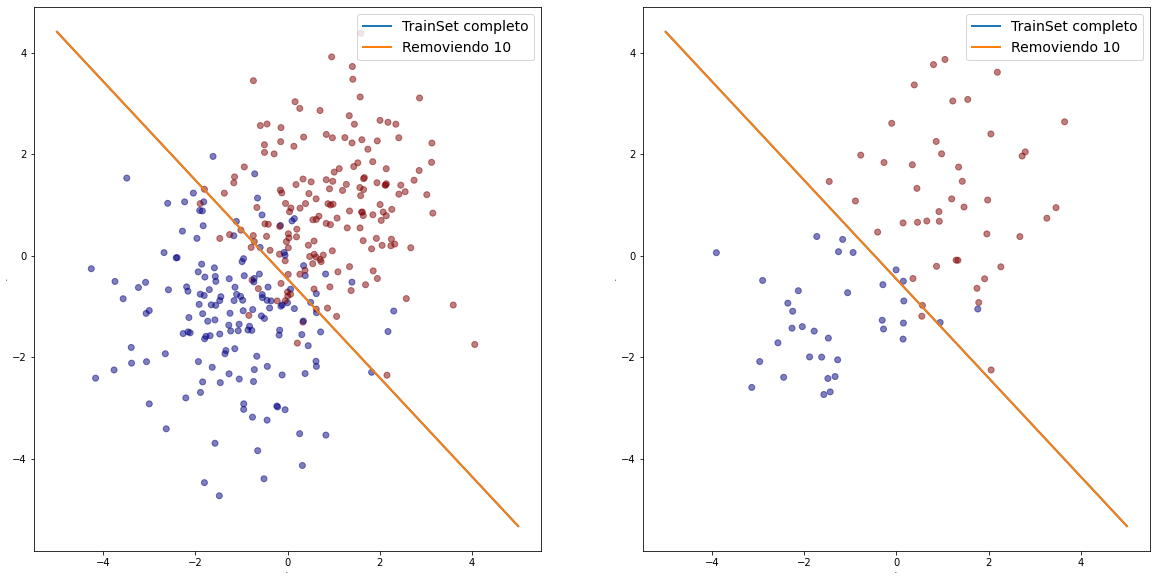

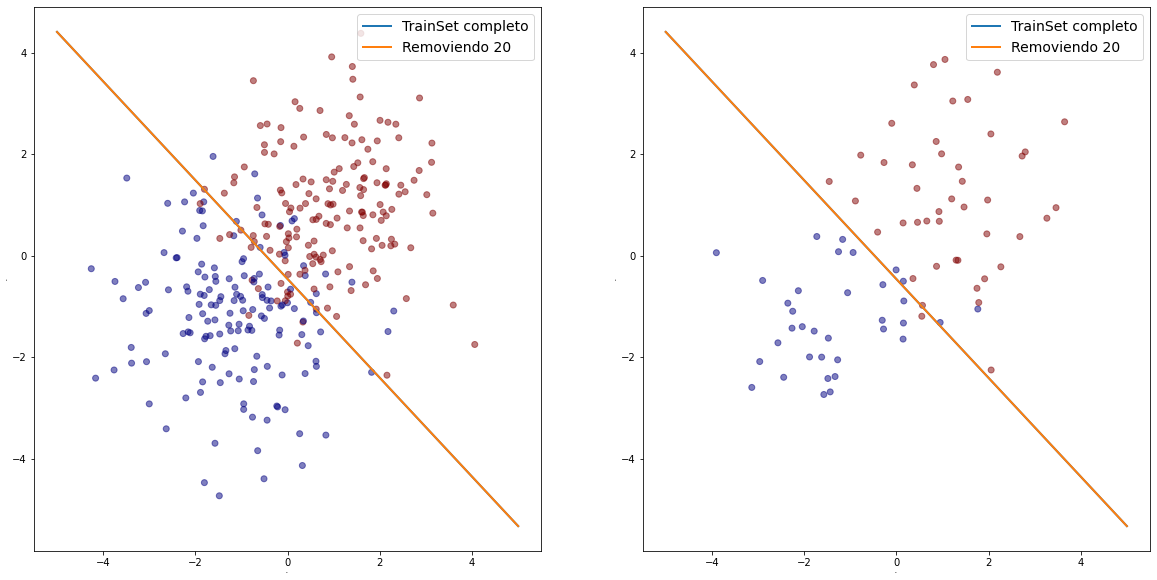

In [14]:
all_index = np.arange(0,len(X_train))
mask = np.isin(all_index, suport_vector_vert, invert = True)
no_support_vector = np.array([i for i,m in enumerate(mask) if(m)])

remove_vector = [1,5,10,20]
for cant in remove_vector:
    
    indx = np.random.choice(no_support_vector,size=cant,replace=False)
    indx = np.sort(indx)[::-1] # Remuevo del mayor al menor
    
    X_train_cut = X_train
    y_train_cut = y_train
    for i in indx:
        X_train_cut = np.delete(X_train_cut, i, 0)
        y_train_cut = np.delete(y_train_cut, i, 0)  
        
    svm=SVC(kernel='linear',C=.1)
    svm.fit(X_train_cut,y_train_cut)      # entrenar SVM
    w = svm.coef_[0]                      # vector w
    b = svm.intercept_                    # valor de b
    score = svm.score(X_test,y_test)      # score
    pred = svm.predict(X_test)            # predicciones
    print(" ")
    print("Removiendo "+str(cant)+" vectores soportes")
    print("Se predijeron correctamente "+str((y_test-pred==0).sum())+" de "+str(len(y_test))+" datos.")
    print("Precisión = "+str(score*100)+"%")
    print("w = " + str(w) + ", b = "+ str(b))
    
    plot_train_test_compare(w_skl,b_skl,"TrainSet completo",w,b,"Removiendo "+str(cant))